In [21]:
## notebook to generate the figures for the paper
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib, numbers
import scipy.optimize as opt
import scipy.signal as sig
from matplotlib.backends.backend_pdf import PdfPages


First the figure for the charge changes over time

In [18]:
file_label = "20231009"
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"
data_dir = os.path.join(code_path, "data", file_label)
charge_data = np.load(data_dir+"/charge_data_%s.npz"%file_label)
for k in charge_data.keys():
    exec("%s = charge_data['%s']"%(k,k))

(0.0, 68.81139719367027)

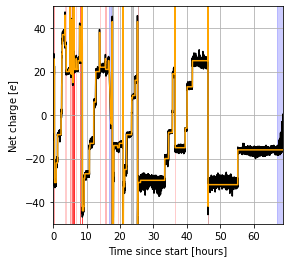

In [37]:
importlib.reload(bu)
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
#plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
t12 = 10.6
xv1, xv2 = 0, time_vals[-1]
time_vals = time_hours[1:]
plt.plot(time_vals, corr_vec[1:,corr_idx]/cal_fac, 'k-', label="Correlation")
plt.plot(time_vals, running_charge, '-', color='orange', label="Recon. charge")
plt.grid(True)
bu.fill_dps(dead_period_edges)
bu.fill_dps(lamp_period_edges, 'black', lab="UV lamp")
bu.fill_dps(filament_period_edges, 'red', lab="Filament")
plt.xlabel("Time since start [hours]")
plt.ylabel("Net charge [$e$]")
#plt.legend(loc="lower right")
plt.ylim(-50,50)
plt.gca().set_xscale('log')
plt.xlim(xv1, xv2)